In [1]:
import sqlite3
import pandas as pd
import csv

# Function to read the CSV file and return data as a list of dictionaries
def read_csv_file(file_path):
    try:
        with open(file_path, 'r') as file:
            # Read the file as raw lines first to debug
            raw_lines = file.readlines()
            print(f"Raw lines read from file: {len(raw_lines)}")
            # Print the first few lines for debugging
            print(f"First 5 raw lines: {raw_lines[:5]}")
            # Proceed with csv.DictReader
            file.seek(0)  # Reset file pointer to the start of the file
            csv_reader = csv.DictReader(file)
            data = [row for row in csv_reader]
            print(f"Loaded {len(data)} rows from the file.")
            # Check the first few rows to ensure the data is in dictionary format
            if data:
                print(f"First row in data: {data[0]}")
            else:
                print("No data found.")
            return data
    except Exception as e:
        print(f"Error reading file: {e}")
        return []

file_path = "train.csv"
data = read_csv_file(file_path)
if data:
    print("Data loaded successfully")
else:
    print("No data loaded")


Raw lines read from file: 100001
First 5 raw lines: ['ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score\n', '5634,3392,1,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.8433333333328,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3.0,7.0,11.27,4.0,Good,809.98,26.822619623699016,265.0,No,49.57494921489417,21.465380264657146,High_spent_Small_value_payments,312.49408867943663,Good\n', '5635,3392,2,Aaron Maashoh,23.0,821000265.0,Scientist,19114.12,1824.8433333333328,3.0,4.0,3.0,4.0,"Auto Loan, Credit-Builder Loan, Personal Loan, and Home Equity Loan",3.0,4.0,11.27,4.0,Good,809.

In [2]:
def create_database():
    try:
        # Connect to SQLite database
        conn = sqlite3.connect("credit_score.db")
        cursor = conn.cursor()

        # Create tables
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Customers (
                Customer_ID TEXT PRIMARY KEY,
                Name TEXT,
                Age INTEGER,
                SSN TEXT UNIQUE,
                Occupation TEXT,
                Annual_Income REAL
            );
        ''')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Credit_Details (
                Customer_ID TEXT,
                Credit_Score TEXT,
                Monthly_Inhand_Salary REAL,
                Num_Bank_Accounts INTEGER,
                Num_Credit_Card INTEGER,
                Interest_Rate REAL,
                Num_of_Loan INTEGER,
                Delay_from_due_date INTEGER,
                Num_of_Delayed_Payment INTEGER,
                Changed_Credit_Limit REAL,
                Num_Credit_Inquiries INTEGER,
                Credit_Mix TEXT,
                Outstanding_Debt REAL,
                Credit_Utilization_Ratio REAL,
                Credit_History_Age TEXT,
                FOREIGN KEY (Customer_ID) REFERENCES Customers(Customer_ID)
            );
        ''')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS Loan_Details (
                Customer_ID TEXT,
                Type_of_Loan TEXT,
                Total_EMI_per_month REAL,
                Payment_of_Min_Amount TEXT,
                Amount_invested_monthly REAL,
                Payment_Behaviour TEXT,
                Monthly_Balance REAL,
                FOREIGN KEY (Customer_ID) REFERENCES Customers(Customer_ID)
            );
        ''')

        conn.commit()
        print("Database and tables created successfully!")
        conn.close()
    except Exception as e:
        print(f"Error creating database: {e}")

create_database()


Database and tables created successfully!


In [3]:
# Function to populate the database
def populate_database(data):
    try:
        conn = sqlite3.connect("credit_score.db")
        cursor = conn.cursor()

        for i, row in enumerate(data):
            print(f"Processing row {i + 1}: {row}")
            try:
                # Convert numeric values safely
                age = int(row['Age']) if row['Age'].isdigit() else None
                annual_income = float(row['Annual_Income']) if row['Annual_Income'] else None
                monthly_inhand_salary = float(row['Monthly_Inhand_Salary']) if row['Monthly_Inhand_Salary'] else None
                num_bank_accounts = int(row['Num_Bank_Accounts']) if row['Num_Bank_Accounts'].isdigit() else None

                # Insert into Customers
                cursor.execute('''
                    INSERT OR IGNORE INTO Customers (Customer_ID, Name, Age, SSN, Occupation, Annual_Income)
                    VALUES (?, ?, ?, ?, ?, ?)
                ''', (row['Customer_ID'], row['Name'], age, row['SSN'], row['Occupation'], annual_income))

                # Insert into Credit_Details
                cursor.execute('''
                    INSERT OR IGNORE INTO Credit_Details (Customer_ID, Credit_Score, Monthly_Inhand_Salary,
                        Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, Num_of_Loan, Delay_from_due_date,
                        Num_of_Delayed_Payment, Changed_Credit_Limit, Num_Credit_Inquiries, Credit_Mix,
                        Outstanding_Debt, Credit_Utilization_Ratio, Credit_History_Age)
                    VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                ''', (row['Customer_ID'], row['Credit_Score'], monthly_inhand_salary,
                      num_bank_accounts, int(row['Num_Credit_Card']), float(row['Interest_Rate']),
                      int(row['Num_of_Loan']), int(row['Delay_from_due_date']),
                      int(row['Num_of_Delayed_Payment']), float(row['Changed_Credit_Limit']),
                      int(row['Num_Credit_Inquiries']), row['Credit_Mix'],
                      float(row['Outstanding_Debt']), float(row['Credit_Utilization_Ratio']),
                      row['Credit_History_Age']))

                # Insert into Loan_Details
                cursor.execute('''
                    INSERT OR IGNORE INTO Loan_Details (Customer_ID, Type_of_Loan, Total_EMI_per_month,
                        Payment_of_Min_Amount, Amount_invested_monthly, Payment_Behaviour, Monthly_Balance)
                    VALUES (?, ?, ?, ?, ?, ?, ?)
                ''', (row['Customer_ID'], row['Type_of_Loan'], float(row['Total_EMI_per_month']),
                      row['Payment_of_Min_Amount'], float(row['Amount_invested_monthly']),
                      row['Payment_Behaviour'], float(row['Monthly_Balance'])))
            except Exception as e:
                print(f"Error processing row {i + 1}: {e}")

        conn.commit()
        print("Data populated successfully!")
        conn.close()
    except Exception as e:
        print(f"Error populating database: {e}")

# Function to verify database contents
def check_database():
    try:
        conn = sqlite3.connect("credit_score.db")
        cursor = conn.cursor()
        cursor.execute("SELECT * FROM Customers LIMIT 5;")
        rows = cursor.fetchall()
        print("Sample data from Customers table:", rows)
        conn.close()
    except Exception as e:
        print(f"Error checking database: {e}")


In [4]:
def fetch_data(conn):
    try:
        query = """
        SELECT Customers.Name, Customers.Age, Customers.Gender, Customers.Income,
               CreditScores.Score, CreditScores.Date,
               Loans.LoanType, Loans.Amount, Loans.Status
        FROM Customers
        JOIN CreditScores ON Customers.CustomerID = CreditScores.CustomerID
        JOIN Loans ON Customers.CustomerID = Loans.CustomerID;
        """
        cursor = conn.cursor()
        cursor.execute(query)
        data = cursor.fetchall()
        columns = [desc[0] for desc in cursor.description]
        df = pd.DataFrame(data, columns=columns)
        return df
    except Exception as e:
        print(f"Error fetching data: {e}")
        return None


### Data Cleaning and Preprocessing


In [6]:
# Convert the list to a pandas DataFrame
data = pd.DataFrame(data)
# 1. Renaming the columns (convert to lowercase and replace spaces with underscores)
data.columns = [col.replace(" ", "_").lower() for col in data.columns]
# 2. Renaming the index
data = data.rename_axis('index')

In [7]:
# 3. Droping the columns that are irrelevant for analysis
data = data.drop(columns=['age', 'ssn'])

In [8]:
# 4. Splitting one column into two
# Convert 'credit_history_age' to an integer (number of months)
data['credit_history_age'] = data['credit_history_age'].astype(float)

# Extract years and months from 'credit_history_age'
data['credit_history_years'] = data['credit_history_age'] // 12  # Integer division to get the number of years
data['credit_history_months'] = data['credit_history_age'] % 12  # Remainder gives the number of months

# Optionally, you can convert the months to integers
data['credit_history_years'] = data['credit_history_years'].astype(int)
data['credit_history_months'] = data['credit_history_months'].astype(int)

In [9]:
# 5. Combining two columns into one
# Combining 'monthly_inhand_salary' and 'annual_income' into 'total_income'
data['total_income'] = data['monthly_inhand_salary'] * 12 + data['annual_income']


In [10]:
# 6. Removing Non-Data Rows
data = data.dropna(how='all')

In [11]:
# 7. Remove repeated rows or duplicate rows
data = data.drop_duplicates()

In [12]:
# 8. Standardizing strings stripping whitespace and converting to lowercase
data['occupation'] = data['occupation'].str.strip().str.lower()

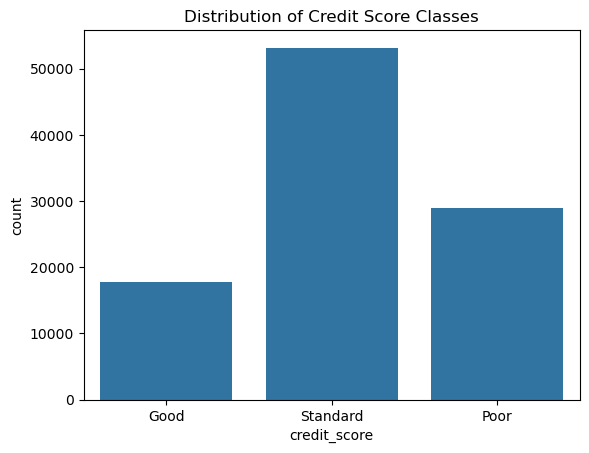

Class Distribution:
 credit_score
Standard    0.53174
Poor        0.28998
Good        0.17828
Name: proportion, dtype: float64
Train/Test split completed.
Training set size: 80000, Testing set size: 20000


In [13]:
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize target variable distribution
sns.countplot(x='credit_score', data=data)
plt.title("Distribution of Credit Score Classes")
plt.show()

# Check class distribution
class_counts = data['credit_score'].value_counts(normalize=True)
print("Class Distribution:\n", class_counts)

# Perform stratified train/test split if necessary
X = data.drop('credit_score', axis=1)
y = data['credit_score']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/Test split completed.")
print(f"Training set size: {len(X_train)}, Testing set size: {len(X_test)}")

In [14]:
from ydata_profiling import ProfileReport

# Select a subset of columns for the analysis (adjust column names based on the actual ones)
selected_columns = ['occupation', 'annual_income', 'credit_score', 'credit_history_age', 'num_credit_card', 'monthly_inhand_salary']

# Check if all selected columns are present in the data
missing_cols = [col for col in selected_columns if col not in data.columns]
if missing_cols:
    print(f"Warning: The following columns are missing from the data: {missing_cols}")
else:
    data_subset = data[selected_columns]

    # Generate the EDA report on the subset of data
    profile = ProfileReport(data_subset, title="Credit Score EDA", explorative=True)

    # Save the report as an HTML file
    profile.to_file("credit_score_eda_subset.html")

    print("EDA report generated and saved as credit_score_eda_subset.html")


/opt/anaconda3/lib/python3.12/site-packages/ydata_profiling/utils/dataframe.py:137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={"index": "df_index"}, inplace=True)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

EDA report generated and saved as credit_score_eda_subset.html


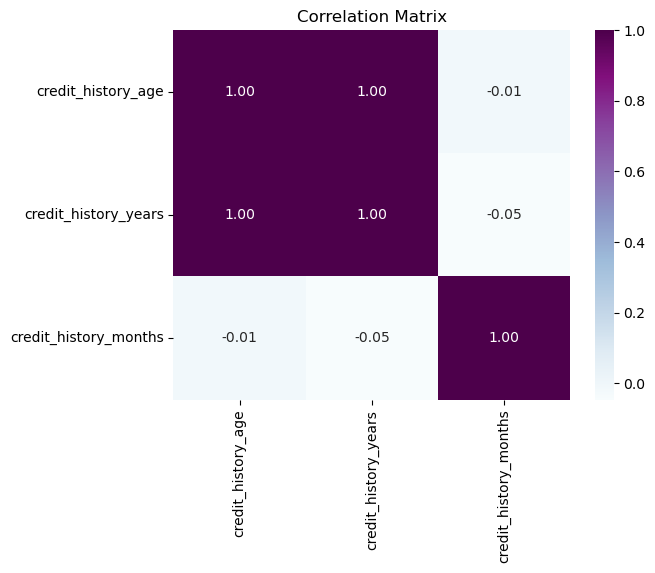

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute the correlation matrix for numerical columns
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = data[numerical_cols].corr()

# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="BuPu", cbar=True)
plt.title("Correlation Matrix")
plt.show()


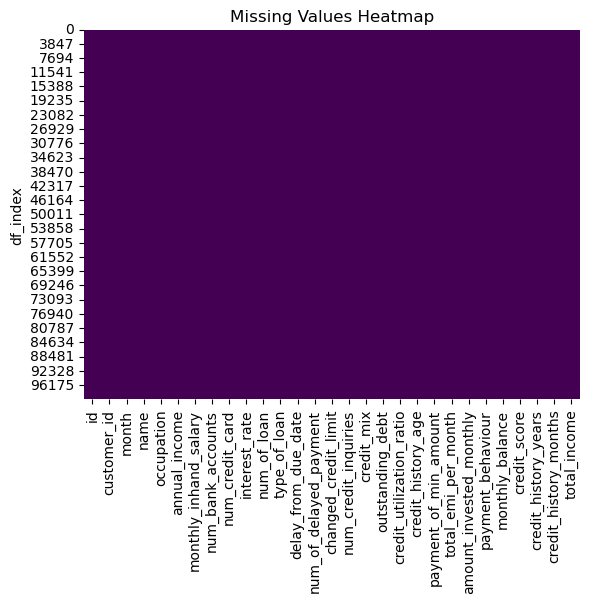

Missing values in each column:
id                          0
customer_id                 0
month                       0
name                        0
occupation                  0
annual_income               0
monthly_inhand_salary       0
num_bank_accounts           0
num_credit_card             0
interest_rate               0
num_of_loan                 0
type_of_loan                0
delay_from_due_date         0
num_of_delayed_payment      0
changed_credit_limit        0
num_credit_inquiries        0
credit_mix                  0
outstanding_debt            0
credit_utilization_ratio    0
credit_history_age          0
payment_of_min_amount       0
total_emi_per_month         0
amount_invested_monthly     0
payment_behaviour           0
monthly_balance             0
credit_score                0
credit_history_years        0
credit_history_months       0
total_income                0
dtype: int64


In [16]:
# 3. Missing Values: Checking for Missing Data
missing_values = data.isnull().sum()

# Plot missing values as a heatmap for better visualization
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap")
plt.show()

print("Missing values in each column:")
print(missing_values)

In [17]:
# 4. Feature Observations
# Checking basic statistics for numerical columns
print("Basic Statistics for Numerical Features:")
print(data.describe())

# Checking for skewness in numerical columns (can help with transformations like log)
print("Skewness for Numerical Features:")
print(data[numerical_cols].skew())


Basic Statistics for Numerical Features:
       credit_history_age  credit_history_years  credit_history_months
count       100000.000000         100000.000000           100000.00000
mean           221.220460             17.969060                5.59174
std             99.680716              8.315032                3.44860
min              1.000000              0.000000                0.00000
25%            144.000000             12.000000                3.00000
50%            219.000000             18.000000                5.00000
75%            302.000000             25.000000                9.00000
max            404.000000             33.000000               11.00000
Skewness for Numerical Features:
credit_history_age      -0.048832
credit_history_years    -0.048033
credit_history_months   -0.006918
dtype: float64


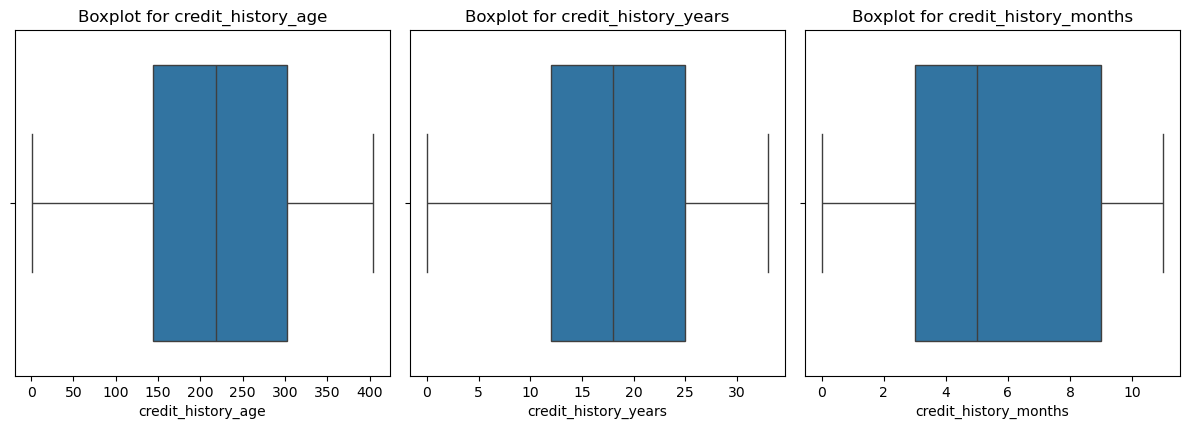

In [18]:
# 5. Capped Values and Outlier Treatment
# Identify outliers by looking at the quantiles and visualizing with boxplots
plt.figure(figsize=(12, 8))
for col in numerical_cols:
    plt.subplot(2, 3, numerical_cols.get_loc(col) + 1)
    sns.boxplot(x=data[col])
    plt.title(f"Boxplot for {col}")

plt.tight_layout()
plt.show()

## Experiment 1


# DagsHub integration
# MLFLOW_TRACKING_URI = "https://dagshub.com/mahmoodalikhan7/credit-score-python-projec.mlflow"

fc2c6409e24688aa20a6c9256d52c07659b4ad50

In [21]:
import os
import logging
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set DagsHub token and tracking URI
dagshub_token = "fc2c6409e24688aa20a6c9256d52c07659b4ad50"  # Replace with your token
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahmoodalikhan7"  # Replace with your DagsHub username
os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
tracking_uri = "https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow"

# Configure MLFlow
mlflow.set_tracking_uri(tracking_uri)

# Test MLFlow connection
try:
    with mlflow.start_run():
        logger.info("Connected to MLFlow on DagsHub successfully!")
except Exception as e:
    logger.error(f"Failed to connect to MLFlow: {e}")
    raise SystemExit("Exiting: Ensure your DagsHub URI and token are correct.")

# Load dataset
try:
    data = pd.read_csv("train.csv")  
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Dataset not found. Please ensure the dataset is in the correct location.")
    raise SystemExit("Exiting: Dataset not found.")
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Define columns
categorical_cols = ['Occupation', 'Credit_Mix', 'Credit_History_Age']  
numerical_cols = ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate']

# Ensure the columns exist in the dataset
missing_numerical_cols = [col for col in numerical_cols if col not in data.columns]
if missing_numerical_cols:
    logger.error(f"Missing numerical columns: {missing_numerical_cols}")
    raise SystemExit(f"Exiting: Missing columns {missing_numerical_cols}")

# Define target column
target_col = 'Credit_Score'  

# Encode target labels (e.g., 'Good', 'Poor', 'Standard') into integers
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

# Split data into features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Convert numerical columns that may have missing values to float64
X_train[numerical_cols] = X_train[numerical_cols].astype('float64')
X_test[numerical_cols] = X_test[numerical_cols].astype('float64')

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ]
)

# Define model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Hyperparameter tuning grid
param_grid = {
    'classifier__C': [0.1, 1.0, 10.0],
    'classifier__penalty': ['l2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1)

# Start MLFlow experiment
with mlflow.start_run() as run:
    # Train model with GridSearchCV
    grid_search.fit(X_train, y_train)

    # Log best parameters
    best_params = grid_search.best_params_
    mlflow.log_params(best_params)

    # Log metrics
    y_pred = grid_search.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    mlflow.log_metric("f1_score", f1)
    
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        mlflow.log_metrics({"TN": tn, "FP": fp, "FN": fn, "TP": tp})
    else:  # Multi-class classification
        for i in range(cm.shape[0]):
            mlflow.log_metric(f"true_positives_class_{i}", cm[i, i])

    # Create an example input for logging with realistic missing values
    input_example = pd.DataFrame({
        'Monthly_Inhand_Salary': [5000, np.nan],
        'Num_Bank_Accounts': [3, np.nan],
        'Num_Credit_Card': [2, np.nan],
        'Interest_Rate': [5.0, np.nan],
        'Occupation': ['Engineer', 'Doctor'],
        'Credit_Mix': ['Good', 'Poor'],
        'Credit_History_Age': [5, np.nan]
    })

    # Infer the signature based on this example
    signature = mlflow.models.infer_signature(input_example, grid_search.predict(input_example))

    # Log the model with signature and input example
    mlflow.sklearn.log_model(
        grid_search.best_estimator_,
        "best_model",
        signature=signature,
        input_example=input_example
    )

    logger.info(f"Experiment completed successfully. View the run at: {mlflow.get_artifact_uri()}/#/experiments/{run.info.experiment_id}/runs/{run.info.run_id}")


INFO:__main__:Connected to MLFlow on DagsHub successfully!


🏃 View run efficient-bug-562 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/beef231966844676a5e710f0c3266058
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Dataset loaded successfully.
INFO:__main__:Experiment completed successfully. View the run at: mlflow-artifacts:/cd5d908d40034c5bb0e99b02ea095ed9/3f60c938f691409db4dc9e33b7cea529/artifacts/#/experiments/0/runs/3f60c938f691409db4dc9e33b7cea529


🏃 View run resilient-gnu-198 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/3f60c938f691409db4dc9e33b7cea529
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


### Experiment 2

In [30]:
import os
import logging
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set DagsHub token and tracking URI
dagshub_token = "fc2c6409e24688aa20a6c9256d52c07659b4ad50"  # Replace with your token
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahmoodalikhan7"  # Replace with your DagsHub username
os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
tracking_uri = "https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow"

# Configure MLFlow
mlflow.set_tracking_uri(tracking_uri)

# Test MLFlow connection
try:
    with mlflow.start_run():
        logger.info("Connected to MLFlow on DagsHub successfully!")
except Exception as e:
    logger.error(f"Failed to connect to MLFlow: {e}")
    raise SystemExit("Exiting: Ensure your DagsHub URI and token are correct.")

# Load dataset
try:
    data = pd.read_csv("train.csv")  # Replace with your actual dataset path
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Dataset not found. Please ensure the dataset is in the correct location.")
    raise SystemExit("Exiting: Dataset not found.")
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Handle missing values: Impute missing values with mean for numerical columns
numerical_cols = ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate']
categorical_cols = ['Occupation', 'Credit_Mix', 'Credit_History_Age']
target_col = 'Credit_Score'

# Use SimpleImputer to handle missing values for numerical and categorical columns
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numerical and categorical columns
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Ensure all numerical columns are of type float64 (forcefully convert all numerical data to float64)
data[numerical_cols] = data[numerical_cols].astype('float64')

# Encode target labels (e.g., 'Good', 'Poor', 'Standard') into integers
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

# Ensure the target column is of type int (for classification task)
data[target_col] = data[target_col].astype('int')

# Convert all columns (numerical and categorical) to str temporarily for MLFlow
data = data.astype('str')

# Split data into features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with mean
            ('scaler', StandardScaler())  # Scale the data
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_cols)
    ]
)

# Models to train
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(eval_metric="mlogloss")  # Removed the 'use_label_encoder' argument
}

# Start MLFlow experiment
for model_name, model in models.items():
    with mlflow.start_run():
        logger.info(f"Training model: {model_name}")
        
        # Define model pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Hyperparameter tuning grid for each model (can be customized)
        if model_name == "LogisticRegression":
            param_grid = {'classifier__C': [0.1, 1.0, 10.0], 'classifier__penalty': ['l2']}
        elif model_name == "RidgeClassifier":
            param_grid = {'classifier__alpha': [0.1, 1.0, 10.0]}
        elif model_name == "RandomForestClassifier":
            param_grid = {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10]}
        elif model_name == "XGBClassifier":
            param_grid = {'classifier__learning_rate': [0.01, 0.1], 'classifier__n_estimators': [100, 200]}
        
        # Set up GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='f1_macro', n_jobs=-1)
        
        # Train model with GridSearchCV
        grid_search.fit(X_train, y_train)

        # Log best parameters
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        # Log metrics
        y_pred = grid_search.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        mlflow.log_metric("f1_score", f1)
        
        if cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = cm.ravel()
            mlflow.log_metrics({"TN": tn, "FP": fp, "FN": fn, "TP": tp})
        else:  # Multi-class classification
            for i in range(cm.shape[0]):
                mlflow.log_metric(f"true_positives_class_{i}", cm[i, i])

        # Log cross-validation results
        cv_results = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=3, scoring='f1_macro')
        mlflow.log_metric("cv_mean_f1", np.mean(cv_results))
        mlflow.log_metric("cv_std_f1", np.std(cv_results))

        # Log the model with input_example for model signature inference
        input_example = X_train.iloc[:1]  # Take one example from the training set
        mlflow.sklearn.log_model(grid_search.best_estimator_, f"{model_name}_best_model", input_example=input_example)

        logger.info(f"Experiment for {model_name} completed successfully.")
        logger.info(f"View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")


INFO:__main__:Connected to MLFlow on DagsHub successfully!


🏃 View run rogue-cow-729 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/91ce0e6ebf2d4ddbb55eb4e91b3f5f20
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Dataset loaded successfully.
INFO:__main__:Training model: LogisticRegression
INFO:__main__:Experiment for LogisticRegression completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/1aed2d5edbe34691ad0403c4954059f0


🏃 View run thundering-gull-907 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/1aed2d5edbe34691ad0403c4954059f0
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: RidgeClassifier
INFO:__main__:Experiment for RidgeClassifier completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/6c7e6f713c2f426488410013fb238c63


🏃 View run nervous-tern-331 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/6c7e6f713c2f426488410013fb238c63
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: RandomForestClassifier
INFO:__main__:Experiment for RandomForestClassifier completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/5046b7366c9c4c65a30160a6b07a9afc


🏃 View run bright-zebra-130 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/5046b7366c9c4c65a30160a6b07a9afc
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: XGBClassifier


🏃 View run gregarious-fish-546 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/e2c2e91ce6d148a78025c3fb3d96ecf7
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


ValueError: 
All the 12 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/pipeline.py", line 473, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/xgboost/sklearn.py", line 1491, in fit
    raise ValueError(
ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['0' '1' '2']


## Experiment 3

In [35]:
import os
import logging
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set DagsHub token and tracking URI
dagshub_token = "fc2c6409e24688aa20a6c9256d52c07659b4ad50"  # Replace with your token
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahmoodalikhan7"  # Replace with your DagsHub username
os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
tracking_uri = "https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow"

# Configure MLFlow
mlflow.set_tracking_uri(tracking_uri)

# Test MLFlow connection
try:
    with mlflow.start_run():
        logger.info("Connected to MLFlow on DagsHub successfully!")
except Exception as e:
    logger.error(f"Failed to connect to MLFlow: {e}")
    raise SystemExit("Exiting: Ensure your DagsHub URI and token are correct.")

# Load dataset
try:
    data = pd.read_csv("train.csv")  # Replace with your actual dataset path
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Dataset not found. Please ensure the dataset is in the correct location.")
    raise SystemExit("Exiting: Dataset not found.")
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Feature Engineering: Create new features and combine attributes
logger.info("Performing feature engineering and attribute combination.")
data['total_accounts'] = data['Num_Bank_Accounts'] + data['Num_Credit_Card']
data['Salary_to_Interest_Rate_Ratio'] = data['Monthly_Inhand_Salary'] / data['Interest_Rate']
logger.info("New features created: total_accounts, Salary_to_Interest_Rate_Ratio")

# Handle missing values: Impute missing values with mean for numerical columns
numerical_cols = ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'total_accounts', 'Salary_to_Interest_Rate_Ratio']
categorical_cols = ['Occupation', 'Credit_Mix', 'Credit_History_Age']
target_col = 'Credit_Score'

# Encode target labels (e.g., 'Good', 'Poor', 'Standard') into integers
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

# Convert numerical columns to float64 explicitly to prevent the warning
data[numerical_cols] = data[numerical_cols].astype('float64')

# Handle missing values for both numerical and categorical columns
def handle_missing_values(df, numerical_cols, categorical_cols):
    """Impute missing values for numerical and categorical columns."""
    # Impute missing numerical values using mean
    numerical_imputer = SimpleImputer(strategy='mean')
    df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])
    
    # Impute missing categorical values using the most frequent value (mode)
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    df[categorical_cols] = categorical_imputer.fit_transform(df[categorical_cols])
    
    return df

data = handle_missing_values(data, numerical_cols, categorical_cols)

# Ensure all columns are converted to the appropriate types to avoid missing value issues
data[numerical_cols] = data[numerical_cols].astype('float64')

# Split data into features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values for numerical features
            ('scaler', StandardScaler())  # Scale the numerical features
        ]), numerical_cols),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing values for categorical features
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
        ]), categorical_cols)
    ]
)

# Models to train
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(eval_metric="mlogloss")  # Removed the 'use_label_encoder' argument
}

# Start MLFlow experiment for feature engineering and model training
for model_name, model in models.items():
    with mlflow.start_run():
        logger.info(f"Training model: {model_name}")
        
        # Define model pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Hyperparameter tuning grid for each model (can be customized)
        if model_name == "LogisticRegression":
            param_grid = {'classifier__C': [0.1, 1.0, 10.0], 'classifier__penalty': ['l2']}
        elif model_name == "RidgeClassifier":
            param_grid = {'classifier__alpha': [0.1, 1.0, 10.0]}
        elif model_name == "RandomForestClassifier":
            param_grid = {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10]}
        elif model_name == "XGBClassifier":
            param_grid = {'classifier__learning_rate': [0.01, 0.1], 'classifier__n_estimators': [100, 200]}
        
        # Set up GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1)
        
        # Train model with GridSearchCV
        grid_search.fit(X_train, y_train)

        # Log best parameters
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        # Log metrics
        y_pred = grid_search.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        mlflow.log_metric("f1_score", f1)
        
        if cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = cm.ravel()
            mlflow.log_metrics({"TN": tn, "FP": fp, "FN": fn, "TP": tp})
        else:  # Multi-class classification
            for i in range(cm.shape[0]):
                mlflow.log_metric(f"true_positives_class_{i}", cm[i, i])

        # Log cross-validation results
        cv_results = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=3, scoring='f1_macro')
        mlflow.log_metric("cv_mean_f1", np.mean(cv_results))
        mlflow.log_metric("cv_std_f1", np.std(cv_results))

        # Log the model with input_example for model signature inference
        input_example = X_train.iloc[:1]  # Take one example from the training set
        mlflow.sklearn.log_model(grid_search.best_estimator_, f"{model_name}_best_model", input_example=input_example)

        logger.info(f"Experiment for {model_name} completed successfully.")
        logger.info(f"View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")


INFO:__main__:Connected to MLFlow on DagsHub successfully!


🏃 View run upset-wolf-311 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/4b8e910c9b424205813b8d6d5ea1340e
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Dataset loaded successfully.
INFO:__main__:Performing feature engineering and attribute combination.
INFO:__main__:New features created: total_accounts, Salary_to_Interest_Rate_Ratio
INFO:__main__:Training model: LogisticRegression
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn

🏃 View run sassy-loon-645 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/62cf67104d7d4700b15103dc3ab3c864
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: RidgeClassifier
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If yo

🏃 View run victorious-finch-57 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/6bd0ba09cb7841e18f9cb02e34a8d47f
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: RandomForestClassifier
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values

🏃 View run welcoming-fly-74 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/3a4fc592b3154e50b6b800566882ea01
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: XGBClassifier
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your

🏃 View run mysterious-lamb-224 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/cc3247c1775b475eabcdd96318ada666
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


## Experiment 4

In [38]:
import os
import logging
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set DagsHub token and tracking URI
dagshub_token = "fc2c6409e24688aa20a6c9256d52c07659b4ad50"  # Replace with your token
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahmoodalikhan7"  # Replace with your DagsHub username
os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
tracking_uri = "https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow"

# Configure MLFlow
mlflow.set_tracking_uri(tracking_uri)

# Test MLFlow connection
try:
    with mlflow.start_run():
        logger.info("Connected to MLFlow on DagsHub successfully!")
except Exception as e:
    logger.error(f"Failed to connect to MLFlow: {e}")
    raise SystemExit("Exiting: Ensure your DagsHub URI and token are correct.")

# Load dataset
try:
    data = pd.read_csv("train.csv")  # Replace with your actual dataset path
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Dataset not found. Please ensure the dataset is in the correct location.")
    raise SystemExit("Exiting: Dataset not found.")
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Handle missing values: Impute missing values with mean for numerical columns
numerical_cols = ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate']
categorical_cols = ['Occupation', 'Credit_Mix', 'Credit_History_Age']
target_col = 'Credit_Score'

# Use SimpleImputer to handle missing values for numerical and categorical columns
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numerical and categorical columns
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Explicitly cast numerical columns and target column to `float64`
data[numerical_cols] = data[numerical_cols].astype('float64')

# Encode target labels (e.g., 'Good', 'Poor', 'Standard') into integers
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

# Convert target variable explicitly to `float64`
data['Credit_Score'] = data['Credit_Score'].astype('float64')

# Split data into features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing pipeline for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with mean
            ('scaler', StandardScaler())  # Scale the data
        ]), numerical_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
        ]), categorical_cols)
    ]
)

# Models to train
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(random_state=42),
    "XGBClassifier": XGBClassifier(eval_metric="mlogloss")  # Removed the 'use_label_encoder' argument
}

# Start MLFlow experiment
for model_name, model in models.items():
    with mlflow.start_run():
        logger.info(f"Training model: {model_name}")
        
        # Define model pipeline
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Hyperparameter tuning grid for each model (can be customized)
        if model_name == "LogisticRegression":
            param_grid = {'classifier__C': [0.1, 1.0, 10.0], 'classifier__penalty': ['l2']}
        elif model_name == "RidgeClassifier":
            param_grid = {'classifier__alpha': [0.1, 1.0, 10.0]}
        elif model_name == "RandomForestClassifier":
            param_grid = {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [5, 10]}
        elif model_name == "XGBClassifier":
            param_grid = {'classifier__learning_rate': [0.01, 0.1], 'classifier__n_estimators': [100, 200]}
        
        # Set up GridSearchCV
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring=make_scorer(f1_score, average='macro'), n_jobs=-1)
        
        # Train model with GridSearchCV
        grid_search.fit(X_train, y_train)

        # Log best parameters
        best_params = grid_search.best_params_
        mlflow.log_params(best_params)

        # Log metrics
        y_pred = grid_search.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='macro')
        cm = confusion_matrix(y_test, y_pred)
        mlflow.log_metric("f1_score", f1)
        
        if cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = cm.ravel()
            mlflow.log_metrics({"TN": tn, "FP": fp, "FN": fn, "TP": tp})
        else:  # Multi-class classification
            for i in range(cm.shape[0]):
                mlflow.log_metric(f"true_positives_class_{i}", cm[i, i])

        # Log cross-validation results
        cv_results = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=3, scoring='f1_macro')
        mlflow.log_metric("cv_mean_f1", np.mean(cv_results))
        mlflow.log_metric("cv_std_f1", np.std(cv_results))

        # Log the model with input_example for model signature inference
        input_example = X_train.iloc[:1]  # Take one example from the training set
        mlflow.sklearn.log_model(grid_search.best_estimator_, f"{model_name}_best_model", input_example=input_example)

        logger.info(f"Experiment for {model_name} completed successfully.")
        logger.info(f"View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")


INFO:__main__:Connected to MLFlow on DagsHub successfully!


🏃 View run luminous-fox-393 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/071c407e6e1d4e398a338b065b998797
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Dataset loaded successfully.
INFO:__main__:Training model: LogisticRegression
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
INFO:__main__:Experiment for LogisticRegression completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-

🏃 View run abundant-gnat-339 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/3ca24be912e8401d876a10f4f5e050c8
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: RidgeClassifier
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
INFO:__main__:Experiment for RidgeClassifier completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/368147

🏃 View run glamorous-gnu-286 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/368147f3f47d4b84bc816d68a0b2e215
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: RandomForestClassifier
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
INFO:__main__:Experiment for RandomForestClassifier completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments

🏃 View run skittish-foal-777 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/d26ed0cc6e9f47daa5236f9412ac2e2a
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Training model: XGBClassifier
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/mlflow/types/utils.py:435: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your

🏃 View run skittish-deer-306 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/387f9868bb674a77b6554a860eb6e694
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


## Experiment 5

In [41]:
import os
import logging
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set DagsHub token and tracking URI
dagshub_token = "fc2c6409e24688aa20a6c9256d52c07659b4ad50"  # Replace with your token
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahmoodalikhan7"  # Replace with your DagsHub username
os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
tracking_uri = "https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow"

# Configure MLFlow
mlflow.set_tracking_uri(tracking_uri)

# Test MLFlow connection
try:
    with mlflow.start_run():
        logger.info("Connected to MLFlow on DagsHub successfully!")
except Exception as e:
    logger.error(f"Failed to connect to MLFlow: {e}")
    raise SystemExit("Exiting: Ensure your DagsHub URI and token are correct.")

# Load dataset
try:
    data = pd.read_csv("train.csv")  # Replace with your actual dataset path
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Dataset not found. Please ensure the dataset is in the correct location.")
    raise SystemExit("Exiting: Dataset not found.")
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Handle missing values: Impute missing values with mean for numerical columns
numerical_cols = ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate']
categorical_cols = ['Occupation', 'Credit_Mix', 'Credit_History_Age']
target_col = 'Credit_Score'

# Use SimpleImputer to handle missing values for numerical and categorical columns
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numerical and categorical columns
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Ensure all numerical columns are of type float64 (forcefully convert all numerical data to float64)
data[numerical_cols] = data[numerical_cols].astype('float64')

# Encode target labels (e.g., 'Good', 'Poor', 'Standard') into integers
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

# Split data into features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing pipeline for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with mean
            ('scaler', StandardScaler())  # Scale the data
        ]), numerical_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
        ]), categorical_cols)
    ]
)

# Start MLFlow experiment
with mlflow.start_run():
    logger.info(f"Applying PCA for dimensionality reduction")
    
    # Define PCA transformation
    pca = PCA(n_components=0.95)  # Keep 95% of variance (you can also set a fixed number of components)
    
    # Define model pipeline with PCA
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('pca', pca),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Fit the pipeline to the training data
    pipeline.fit(X_train, y_train)
    
    # Log PCA components and explained variance ratio
    pca_components = pca.components_
    explained_variance_ratio = pca.explained_variance_ratio_
    mlflow.log_metric("explained_variance_ratio", np.sum(explained_variance_ratio))  # Total variance explained by the components
    
    # Create and save PCA components as text file
    pca_components_matrix_path = "pca_components_matrix.txt"  # Save in the current working directory
    with open(pca_components_matrix_path, "w") as f:
        for i, component in enumerate(pca_components):
            f.write(f"Component {i+1}: {component}\n")
    
    # Log the PCA components matrix as an artifact
    mlflow.log_artifact(pca_components_matrix_path)
    
    # Create and save the scree plot
    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.7, align="center")
    plt.ylabel("Explained Variance Ratio")
    plt.xlabel("Principal Components")
    plt.title("Scree Plot: Explained Variance by Principal Components")
    plt.xticks(range(1, len(explained_variance_ratio) + 1))
    scree_plot_path = "scree_plot.png"  # Save in the current working directory
    plt.savefig(scree_plot_path)
    plt.close()
    
    # Log the scree plot
    mlflow.log_artifact(scree_plot_path)

    # Model training after PCA transformation
    y_pred = pipeline.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    mlflow.log_metric("f1_score", f1)
    
    if cm.shape == (2, 2):  # Binary classification
        tn, fp, fn, tp = cm.ravel()
        mlflow.log_metrics({"TN": tn, "FP": fp, "FN": fn, "TP": tp})
    else:  # Multi-class classification
        for i in range(cm.shape[0]):
            mlflow.log_metric(f"true_positives_class_{i}", cm[i, i])

    logger.info(f"Experiment for PCA completed successfully.")
    logger.info(f"View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")


INFO:__main__:Connected to MLFlow on DagsHub successfully!


🏃 View run spiffy-cow-83 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/076d6d92e0884d6d84eb41579e74267b
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Dataset loaded successfully.
INFO:__main__:Applying PCA for dimensionality reduction
INFO:__main__:Experiment for PCA completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/a152abdcb10340a9ac377cbe2e850ca5


🏃 View run peaceful-gnu-239 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/a152abdcb10340a9ac377cbe2e850ca5
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


## Experiment 6

In [44]:
import os
import logging
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set DagsHub token and tracking URI
dagshub_token = "fc2c6409e24688aa20a6c9256d52c07659b4ad50"  # Replace with your token
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahmoodalikhan7"  # Replace with your DagsHub username
os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
tracking_uri = "https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow"

# Configure MLFlow
mlflow.set_tracking_uri(tracking_uri)

# Test MLFlow connection
try:
    with mlflow.start_run():
        logger.info("Connected to MLFlow on DagsHub successfully!")
except Exception as e:
    logger.error(f"Failed to connect to MLFlow: {e}")
    raise SystemExit("Exiting: Ensure your DagsHub URI and token are correct.")

# Load dataset
try:
    data = pd.read_csv("train.csv")  # Replace with your actual dataset path
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Dataset not found. Please ensure the dataset is in the correct location.")
    raise SystemExit("Exiting: Dataset not found.")
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Handle missing values: Impute missing values with mean for numerical columns
numerical_cols = ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate']
categorical_cols = ['Occupation', 'Credit_Mix', 'Credit_History_Age']
target_col = 'Credit_Score'

# Use SimpleImputer to handle missing values for numerical and categorical columns
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numerical and categorical columns
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Ensure all numerical columns are of type float64 (forcefully convert all numerical data to float64)
data[numerical_cols] = data[numerical_cols].astype('float64')

# Encode target labels (e.g., 'Good', 'Poor', 'Standard') into integers
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

# Create custom feature engineering - Interactions between certain columns (for example)
data['Salary_to_Credit_Card_Ratio'] = data['Monthly_Inhand_Salary'] / (data['Num_Credit_Card'] + 1)
data['Salary_to_Bank_Account_Ratio'] = data['Monthly_Inhand_Salary'] / (data['Num_Bank_Accounts'] + 1)

# Split data into features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing pipeline for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with mean
            ('scaler', StandardScaler())  # Scale the data
        ]), numerical_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
        ]), categorical_cols)
    ]
)

# Start MLFlow experiment
with mlflow.start_run():
    logger.info(f"Running custom experiment with RandomForestClassifier and GradientBoostingClassifier")
    
    # Define models to be tested
    models = {
        "RandomForestClassifier": RandomForestClassifier(random_state=42),
        "GradientBoostingClassifier": GradientBoostingClassifier(random_state=42)
    }
    
    for model_name, model in models.items():
        logger.info(f"Training model: {model_name}")
        
        # Define the pipeline with preprocessing and model
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        
        # Predictions
        y_pred = pipeline.predict(X_test)
        
        # Evaluation metrics
        f1 = f1_score(y_test, y_pred, average='macro')
        accuracy = accuracy_score(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        
        # Log metrics to MLFlow
        mlflow.log_metric(f"{model_name}_f1_score", f1)
        mlflow.log_metric(f"{model_name}_accuracy", accuracy)
        
        if cm.shape == (2, 2):  # Binary classification
            tn, fp, fn, tp = cm.ravel()
            mlflow.log_metrics({
                f"{model_name}_TN": tn, 
                f"{model_name}_FP": fp, 
                f"{model_name}_FN": fn, 
                f"{model_name}_TP": tp
            })
        else:  # Multi-class classification
            for i in range(cm.shape[0]):
                mlflow.log_metric(f"{model_name}_true_positives_class_{i}", cm[i, i])
        
        # Save confusion matrix as an image plot
        plt.figure(figsize=(6, 6))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix: {model_name}")
        plt.colorbar()
        tick_marks = np.arange(len(label_encoder.classes_))
        plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
        plt.yticks(tick_marks, label_encoder.classes_)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        
        cm_image_path = f"confusion_matrix_{model_name}.png"
        plt.savefig(cm_image_path)
        plt.close()
        
        # Log confusion matrix image as artifact
        mlflow.log_artifact(cm_image_path)

    logger.info("Custom experiment completed successfully.")
    logger.info(f"View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/{mlflow.active_run().info.experiment_id}/runs/{mlflow.active_run().info.run_id}")


INFO:__main__:Connected to MLFlow on DagsHub successfully!


🏃 View run redolent-goose-337 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/30ee8676f03e4f9c9950a5372a41e106
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Dataset loaded successfully.
INFO:__main__:Running custom experiment with RandomForestClassifier and GradientBoostingClassifier
INFO:__main__:Training model: RandomForestClassifier
INFO:__main__:Training model: GradientBoostingClassifier
INFO:__main__:Custom experiment completed successfully.
INFO:__main__:View the run at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/c141f85ab1b34ea5ac6c8679bea23056


🏃 View run tasteful-fawn-598 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/c141f85ab1b34ea5ac6c8679bea23056
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


## Experiment 7

In [47]:
import os
import logging
import mlflow
import mlflow.sklearn
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Set DagsHub token and tracking URI
dagshub_token = "fc2c6409e24688aa20a6c9256d52c07659b4ad50"  # Replace with your token
os.environ["MLFLOW_TRACKING_USERNAME"] = "mahmoodalikhan7"  # Replace with your DagsHub username
os.environ["MLFLOW_TRACKING_PASSWORD"] = dagshub_token
tracking_uri = "https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow"

# Configure MLFlow
mlflow.set_tracking_uri(tracking_uri)

# Test MLFlow connection
try:
    with mlflow.start_run():
        logger.info("Connected to MLFlow on DagsHub successfully!")
except Exception as e:
    logger.error(f"Failed to connect to MLFlow: {e}")
    raise SystemExit("Exiting: Ensure your DagsHub URI and token are correct.")

# Load dataset
try:
    data = pd.read_csv("train.csv")  # Replace with your actual dataset path
    logger.info("Dataset loaded successfully.")
except FileNotFoundError:
    logger.error("Dataset not found. Please ensure the dataset is in the correct location.")
    raise SystemExit("Exiting: Dataset not found.")
data.columns = data.columns.str.strip()  # Remove any leading/trailing spaces

# Handle missing values: Impute missing values with mean for numerical columns
numerical_cols = ['Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate']
categorical_cols = ['Occupation', 'Credit_Mix', 'Credit_History_Age']
target_col = 'Credit_Score'

# Use SimpleImputer to handle missing values for numerical and categorical columns
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Impute numerical and categorical columns
data[numerical_cols] = numerical_imputer.fit_transform(data[numerical_cols])
data[categorical_cols] = categorical_imputer.fit_transform(data[categorical_cols])

# Ensure all numerical columns are of type float64 (forcefully convert all numerical data to float64)
data[numerical_cols] = data[numerical_cols].astype('float64')

# Encode target labels (e.g., 'Good', 'Poor', 'Standard') into integers
label_encoder = LabelEncoder()
data['Credit_Score'] = label_encoder.fit_transform(data['Credit_Score'])

# Create custom feature engineering - Interactions between certain columns (for example)
data['Salary_to_Credit_Card_Ratio'] = data['Monthly_Inhand_Salary'] / (data['Num_Credit_Card'] + 1)
data['Salary_to_Bank_Account_Ratio'] = data['Monthly_Inhand_Salary'] / (data['Num_Bank_Accounts'] + 1)

# Split data into features and target
X = data.drop(columns=[target_col])
y = data[target_col]

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define preprocessing pipeline for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values with mean
            ('scaler', StandardScaler())  # Scale the data
        ]), numerical_cols),
        
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # One-hot encode categorical features
        ]), categorical_cols)
    ]
)

# Define the parameter grids for Logistic Regression and Random Forest
param_grid_logreg = {
    'classifier': [LogisticRegression(max_iter=1000, random_state=42)],
    'classifier__C': [0.1, 1.0, 10.0],  # Regularization strength
}

param_grid_rf = {
    'classifier': [RandomForestClassifier(random_state=42)],
    'classifier__n_estimators': [100, 200],  # Number of trees in Random Forest
    'classifier__max_depth': [5, 10, None],  # Max depth of trees
}

# Start MLFlow experiment
with mlflow.start_run():
    logger.info(f"Running custom experiment with LogisticRegression and RandomForestClassifier")

    # Experiment for Logistic Regression
    pipeline_logreg = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))  # Default to Logistic Regression
    ])
    
    grid_search_logreg = GridSearchCV(pipeline_logreg, param_grid_logreg, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search_logreg.fit(X_train, y_train)
    
    # Best model for Logistic Regression
    best_model_logreg = grid_search_logreg.best_estimator_
    logger.info(f"Best Logistic Regression model found: {grid_search_logreg.best_params_}")
    
    # Predictions for Logistic Regression
    y_pred_logreg = best_model_logreg.predict(X_test)
    
    # Evaluation metrics for Logistic Regression
    f1_logreg = f1_score(y_test, y_pred_logreg, average='macro')
    accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
    cm_logreg = confusion_matrix(y_test, y_pred_logreg)
    
    # For multiclass ROC AUC, we need to use predict_proba and multi_class='ovr'
    y_prob_logreg = best_model_logreg.predict_proba(X_test)
    roc_auc_logreg = roc_auc_score(y_test, y_prob_logreg, multi_class='ovr')
    
    # Log metrics for Logistic Regression
    mlflow.log_metric("logreg_f1_score", f1_logreg)
    mlflow.log_metric("logreg_accuracy", accuracy_logreg)
    mlflow.log_metric("logreg_roc_auc_score", roc_auc_logreg)
    
    # Log confusion matrix image for Logistic Regression
    plt.figure(figsize=(6, 6))
    plt.imshow(cm_logreg, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Logistic Regression")
    plt.colorbar()
    tick_marks = np.arange(len(label_encoder.classes_))
    plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
    plt.yticks(tick_marks, label_encoder.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    cm_logreg_image_path = "logreg_confusion_matrix.png"
    plt.savefig(cm_logreg_image_path)
    plt.close()
    
    # Log artifact (Confusion Matrix for Logistic Regression)
    mlflow.log_artifact(cm_logreg_image_path)
    
    # Plot ROC curve for Logistic Regression (one-vs-rest for multiclass)
    fpr_logreg, tpr_logreg, thresholds_logreg = {}, {}, {}
    for i in range(len(label_encoder.classes_)):
        fpr_logreg[i], tpr_logreg[i], thresholds_logreg[i] = roc_curve(y_test == i, y_prob_logreg[:, i])
    
    plt.figure(figsize=(10, 8))
    for i in range(len(label_encoder.classes_)):
        plt.plot(fpr_logreg[i], tpr_logreg[i], lw=2, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc_logreg:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Logistic Regression')
    plt.legend(loc='lower right')
    
    roc_logreg_image_path = "logreg_roc_curve.png"
    plt.savefig(roc_logreg_image_path)
    plt.close()
    
    # Log artifact (ROC Curve for Logistic Regression)
    mlflow.log_artifact(roc_logreg_image_path)

    # Experiment for Random Forest Classifier
    pipeline_rf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))  # Default to Random Forest
    ])
    
    grid_search_rf = GridSearchCV(pipeline_rf, param_grid_rf, cv=3, scoring='accuracy', n_jobs=-1)
    grid_search_rf.fit(X_train, y_train)
    
    # Best model for Random Forest
    best_model_rf = grid_search_rf.best_estimator_
    logger.info(f"Best Random Forest model found: {grid_search_rf.best_params_}")
    
    # Predictions for Random Forest
    y_pred_rf = best_model_rf.predict(X_test)
    
    # Evaluation metrics for Random Forest
    f1_rf = f1_score(y_test, y_pred_rf, average='macro')
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    cm_rf = confusion_matrix(y_test, y_pred_rf)
    
    # For multiclass ROC AUC, we need to use predict_proba and multi_class='ovr'
    y_prob_rf = best_model_rf.predict_proba(X_test)
    roc_auc_rf = roc_auc_score(y_test, y_prob_rf, multi_class='ovr')
    
    # Log metrics for Random Forest
    mlflow.log_metric("rf_f1_score", f1_rf)
    mlflow.log_metric("rf_accuracy", accuracy_rf)
    mlflow.log_metric("rf_roc_auc_score", roc_auc_rf)
    
    # Log confusion matrix image for Random Forest
    plt.figure(figsize=(6, 6))
    plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix - Random Forest")
    plt.colorbar()
    tick_marks = np.arange(len(label_encoder.classes_))
    plt.xticks(tick_marks, label_encoder.classes_, rotation=45)
    plt.yticks(tick_marks, label_encoder.classes_)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    cm_rf_image_path = "rf_confusion_matrix.png"
    plt.savefig(cm_rf_image_path)
    plt.close()
    
    # Log artifact (Confusion Matrix for Random Forest)
    mlflow.log_artifact(cm_rf_image_path)
    
    # Plot ROC curve for Random Forest (one-vs-rest for multiclass)
    fpr_rf, tpr_rf, thresholds_rf = {}, {}, {}
    for i in range(len(label_encoder.classes_)):
        fpr_rf[i], tpr_rf[i], thresholds_rf[i] = roc_curve(y_test == i, y_prob_rf[:, i])
    
    plt.figure(figsize=(10, 8))
    for i in range(len(label_encoder.classes_)):
        plt.plot(fpr_rf[i], tpr_rf[i], lw=2, label=f'Class {label_encoder.classes_[i]} (area = {roc_auc_rf:.2f})')
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic - Random Forest')
    plt.legend(loc='lower right')
    
    roc_rf_image_path = "rf_roc_curve.png"
    plt.savefig(roc_rf_image_path)
    plt.close()
    
    # Log artifact (ROC Curve for Random Forest)
    mlflow.log_artifact(roc_rf_image_path)
    
    # Log final run ID and details
    logger.info(f"Run ID: {mlflow.active_run().info.run_id}")
    logger.info(f"View this experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/{mlflow.active_run().info.run_id}")


INFO:__main__:Connected to MLFlow on DagsHub successfully!


🏃 View run languid-panda-682 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/7dfae2878fe74d388c1b37dd6d998918
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


INFO:__main__:Dataset loaded successfully.
INFO:__main__:Running custom experiment with LogisticRegression and RandomForestClassifier
INFO:__main__:Best Logistic Regression model found: {'classifier': LogisticRegression(max_iter=1000, random_state=42), 'classifier__C': 10.0}
INFO:__main__:Best Random Forest model found: {'classifier': RandomForestClassifier(random_state=42), 'classifier__max_depth': None, 'classifier__n_estimators': 200}
INFO:__main__:Run ID: a22eafcd8b274352a4c25a3303a60861
INFO:__main__:View this experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/a22eafcd8b274352a4c25a3303a60861


🏃 View run whimsical-moose-677 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/a22eafcd8b274352a4c25a3303a60861
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


## Step 8

In [48]:
import matplotlib.pyplot as plt
import numpy as np
import mlflow
import mlflow.sklearn
from sklearn.metrics import f1_score

# Create a list to store the F1-scores and corresponding model names
model_names = ['Logistic Regression', 'Random Forest']
f1_scores = [f1_logreg, f1_rf]  # These are F1 scores computed during model evaluation

# Log F1-scores to MLFlow
with mlflow.start_run():
    # Log metrics for Logistic Regression and Random Forest
    mlflow.log_metric("logreg_f1_score", f1_logreg)
    mlflow.log_metric("rf_f1_score", f1_rf)
    
    # Plot F1-scores for comparison
    plt.figure(figsize=(8, 6))
    plt.bar(model_names, f1_scores, color=['blue', 'green'])
    plt.title('F1-Score Comparison for Logistic Regression vs Random Forest')
    plt.xlabel('Model')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)  # F1-score is between 0 and 1
    
    # Save the plot to a file and log it as an artifact
    f1_plot_path = 'f1_score_comparison.png'
    plt.savefig(f1_plot_path)
    plt.close()  # Close the plot after saving
    
    # Log the F1-score plot as an artifact in MLFlow
    mlflow.log_artifact(f1_plot_path)
    
    logger.info(f"Run ID: {mlflow.active_run().info.run_id}")
    logger.info(f"View this experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/{mlflow.active_run().info.run_id}")


INFO:__main__:Run ID: 799a727f54f445bf9be21b3a8c59814f
INFO:__main__:View this experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/799a727f54f445bf9be21b3a8c59814f


🏃 View run sincere-deer-196 at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0/runs/799a727f54f445bf9be21b3a8c59814f
🧪 View experiment at: https://dagshub.com/mahmoodalikhan7/credit-score-python-project.mlflow/#/experiments/0


### Saving the final model using joblib

In [56]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_iris
import joblib

# Example model training
data = load_iris()
X, y = data.data, data.target
model = RandomForestClassifier()
model.fit(X, y)

# Save the model
joblib.dump(model, "model.joblib")
print("Model saved as model.joblib")


Model saved as model.joblib
